# Self-Driving Car Engineer Nanodegree


## Project: **Advenced Lane Finding** 
***

Advanced Lane Finding Project
The goals / steps of this project are the following:

- Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
- Apply a distortion correction to raw images.
- Use color transforms, gradients, etc., to create a thresholded binary image.
- Apply a perspective transform to rectify binary image ("birds-eye view").
- Detect lane pixels and fit to find the lane boundary.
- Determine the curvature of the lane and vehicle position with respect to center.
- Warp the detected lane boundaries back onto the original image.
- Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.for this project.

---
**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

# Pipeline (single images)
## Ideas for Lane Detection Pipeline
**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`distortion_remover()` for undistortion image 

`binary_image_creater()` for create binary image with feature extraction  

`warp_performer()` to transoform an image to bird'S eye view

## Import Packages

In [31]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import pickle

%matplotlib inline

## Helper Functions

In [32]:
"""
    Helper Function for Removing the camera distortion
"""
def distortion_remover(img):
    """ function:Removing the camera distortion from a image
        aurg1: a RGB image (with camera distortion)
        return: a RGB image (withoute camera distortion) """ 
    
    with open("output_images/dist_pickle.p", "rb") as f:
    # The pickle protocol version used is detected automatically, so we do not have to specify it.
        # Load camera calibration data
        dist_pickle = pickle.load(f)
        # Extract the calibration data
        mtx = dist_pickle["mtx"]
        dist = dist_pickle["dist"]
        
    # Undistortion an image
    undist_img = cv2.undistort(img, mtx, dist, None, mtx)
    return undist_img

"""
    Helper Function for Feature Extraction
"""
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient=="x":
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    if orient=="y":
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

    # Apply threshold
    # 5) Create a mask of 1's where the scaled gradient magnitude 
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # 6) Return this mask as your binary_output image
    return grad_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Calculate the magnitude
    #abs_sobel = np.absolute([sobelx,sobely])
    abs_sobel = np.sqrt(sobelx*sobelx + sobely*sobely)
    
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

    # Apply threshold
    # 5) Create a binary mask where mag thresholds are met
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1

    # 6) Return this mask as your binary_output image
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.sqrt(sobelx*sobelx)
    abs_sobely = np.sqrt(sobely*sobely)
    abs_sobel = np.sqrt(sobelx*sobelx + sobely*sobely)
    
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    sobel_angle = np.arctan2(abs_sobely, abs_sobelx)

    # Apply threshold
    # 5) Create a binary mask where direction thresholds are met
    dir_binary = np.zeros_like(sobel_angle)
    dir_binary[(sobel_angle >= thresh[0]) & (sobel_angle <= thresh[1])] = 1

    # 6) Return this mask as your binary_output image
    return dir_binary

def HLS_thresh(image, channel="s_channel", hls_thresh=(170, 255)):
    """ function: HLS channel converte RGB to binary image
        arg1: original image
        arg2: channel select
        arg3: threshold value
        return: binary image with hls channel """
    # extract H or L or S channel
    # 1) Convert to HSV color space 
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HLS).astype(np.float)
    
    # 2) Separate the V channel
    if channel == "h_channel":
        hls_channel_img = hsv[:,:,0] # h_channel
    if channel == "l_channel":
        hls_channel_img = hsv[:,:,1] # l_channel
    if channel == "s_channel":
        hls_channel_img = hsv[:,:,2] # s_channel
    
    # 3) Apply threshold
    hls_binary = np.zeros_like(hls_channel_img)
    hls_binary[(hls_channel_img >= hls_thresh[0]) & (hls_channel_img <= hls_thresh[1])] = 1
    
    # 4) Return this mask as your binary_output image
    return hls_binary

def binary_image_creater(image):
    """ Function: Make binary image with image features
        arg: RGB image
        return: binary image result,
                color_binary_image (its for develop),
                binary image crated with all features (its for develop)"""
    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx_binary = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(25, 255))
    grady_binary = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(25, 255))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3))

    # Apply each defference color channels
    S_binary   = HLS_thresh(image, channel="s_channel", hls_thresh=(200, 255))
    L_binary   = HLS_thresh(image, channel="l_channel", hls_thresh=(230, 255))

    # Combined result of Sobel_x and S-channel in HLS solor space
    color_binary = np.dstack(( np.zeros_like(gradx_binary), gradx_binary, S_binary))
    #print(np.shape(color_binary))

    # Combined image SobelX and S-Channel 
    combined_image = np.zeros_like(dir_binary)
    combined_image[((gradx_binary == 1) | (S_binary == 1) ) | (L_binary == 1)] = 1
    #combined_image[((gradx_binary == 1) | (S_binary == 1) )] = 1
    #print(np.shape(combined_image))

    # Combined ALL image
    combined_all = np.zeros_like(dir_binary)
    combined_all[((gradx_binary == 1) & (grady_binary == 1)) \
                 | ((mag_binary == 1) & (dir_binary == 1)) | (S_binary == 1) | (L_binary == 1)] = 1
    #print(np.shape(combined_all))
    
    return combined_image, color_binary, combined_all

"""
    Helper Function for Perspective Transformation
"""
def warper(img, src, dst):

    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    
    M    = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return warped, M, Minv


def warp_performer(img):
    """ function: Transform an camera viewing image into Bird's eye view
        arg: vcamera image
        retunr: an image from bird's eye view """
    # Get the image size
    img_size = img.shape
    
    # Setting the warp points
    x_src_offset = 60
    y_src_offset = 100
    x_dst_offset = 120 # 55
    y_dst_offset = 150 # 55

    src = np.float32(
        [[(img_size[1]  / 2) - x_src_offset , img_size[0] / 2 + y_src_offset],
        [((img_size[1]  / 4) - 120)         , img_size[0]-1],
        [(img_size[1]*3 / 4) + 150          , img_size[0]-1],
        [(img_size[1]   / 2  + x_src_offset), img_size[0] / 2 + y_src_offset]])
    dst = np.float32(
        [[(img_size[1]/4 - x_dst_offset)    , 0],
        [(img_size[1] /4 - x_dst_offset)    , img_size[0]-1],
        [(img_size[1] *3 / 4 + y_dst_offset), img_size[0]-1],
        [(img_size[1] *3 / 4 + y_dst_offset), 0]])

    # Warping the image
    warped_img, M, Minv = warper(img, src, dst)
    return warped_img, M, Minv

"""
    Helper Function for detecting the curvature and the offset distance of the vehicle
"""
def calc_curvature(ploty, left_fitx, right_fitx):
    """ Function: Calculate the curvature of lane lines
        arg: the position of lanelines
        return; cuvatures of left and right lanes"""
    # Calculate the curvature
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    y_eval = np.max(ploty)

    # Fit new polynomials to x,y in world space
    left_fit_cr  = np.polyfit(ploty*ym_per_pix, left_fitx *xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad  = ((1 + (2*left_fit_cr[0] *y_eval*ym_per_pix + left_fit_cr[1] )**2)**1.5) / np.absolute(2*left_fit_cr[0] )
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    curvature = (left_curverad + right_curverad) /2 

    return curvature

def calc_offset(image, left_fitx, right_fitx):
    """ Function: Calculate the offset distance between the center of lane lines and vehicle
        arg: undistort image and the position of lane lines
        return: offset distance between the center of lane lines and vehicle"""
    # Calculate the offset
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Calculation
    lane_center  = (left_fitx[-1] + right_fitx[-1])/2
    offset_pixel = np.abs(lane_center - image.shape[1]/2)
    offset_m     = offset_pixel*xm_per_pix
    
    return offset_m

"""
    Helper Function for detecting the curvature and the offset distance of the vehicle
"""
def visualize_result(image, warped, Minv, left_fitx, right_fitx, ploty):
    """ Function: Visualize the result of image with lane line
        arg: warped binary image
        return: result of a undistort image with lane lines"""
    # Initialize image
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)

    return result 

# Add the data text to the result image
def add_data_to_image(image, curvature, offset_m):
    """ Function: Add the text to the image
        arg     : Base image, text1, text2
        return  : An image with text1 and text2 """
    # Add texts
    # then put the text itself
    # font = cv2.FONT_HERSHEY_SIMPLEX
    font = cv2.FONT_HERSHEY_PLAIN
    font_size = 2
    thickness = 2

    curvature_str = "the road of curvature: " + str(curvature)
    #print(cur_str)
    offset_str = "the offset of the vehicle: " + str(offset_m)
    #print(offset_str)

    #cv2.putText(result, curvature_str, (180,80), font, font_size, (255,255,255), thickness, cv2.LINE_AA)
    #cv2.putText(result, offset_str,    (180,120), font, font_size, (255,255,255), thickness, cv2.LINE_AA)
    cv2.putText(image, curvature_str, (180,80),  font, font_size, (255,255,255), thickness)
    cv2.putText(image, offset_str,    (180,120), font, font_size, (255,255,255), thickness)

    return image

In [33]:
"""
    Helper Function for finding the Lane Line
"""
def calc_fit(binary_warped):
    """ Function: Find the lane line as sequential X-Y pixcels
        return  : Lane line pixcels """
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[np.int(binary_warped.shape[0]/2):,:], axis=0)
    # Remove -> Create an output image to draw on and  visualize the result
    
    """ Initializing the parameters
        the base point of left and right lane line"""
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    """ the Sliding window settings """
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    """ the Sliding window settings """
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    #print(nonzerox)

    """ the Sliding window settings """
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):

        # Identify window boundaries in x and y (and right and left)
        win_y_low  = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low  = leftx_current  - margin
        win_xleft_high = leftx_current  + margin
        win_xright_low = rightx_current - margin
        win_xright_high= rightx_current + margin

        # Remove -> Draw the windows on the visualization image
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & \
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds= ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & \
                          (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx_for_fit  = nonzerox[left_lane_inds]
    lefty_for_fit  = nonzeroy[left_lane_inds] 
    rightx_for_fit = nonzerox[right_lane_inds]
    righty_for_fit = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit  = np.polyfit(lefty_for_fit,   leftx_for_fit, 2)
    right_fit = np.polyfit(righty_for_fit, rightx_for_fit, 2)
    
    # Generate x and y values for plotting
    # Make y-value for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    # Calculate the x-value for y-value
    left_fitx  = left_fit[0] *ploty**2 + left_fit[1] *ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Remove -> paint colors on lane line image
    return left_fit, right_fit, ploty, left_fitx, right_fitx

def calc_fit_assume(binary_warped, left_fit, right_fit):
    """ Function: Find the Lane Line with Region of interest
        arg     : Warped binary image, coefficient of fitting lane line
        retunr  : Co-efficient of lane line, y-value and each left and right value on lane line """
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx_for_fit  = nonzerox[left_lane_inds]
    lefty_for_fit  = nonzeroy[left_lane_inds] 
    rightx_for_fit = nonzerox[right_lane_inds]
    righty_for_fit = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty_for_fit,   leftx_for_fit, 2)
    right_fit = np.polyfit(righty_for_fit, rightx_for_fit, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx  = left_fit[0] *ploty**2 + left_fit[1] *ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    return left_fit, right_fit, ploty, left_fitx, right_fitx

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


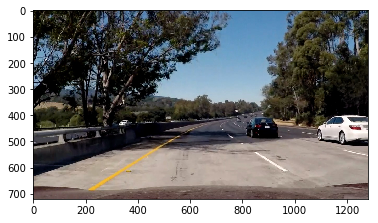

In [34]:
#reading in an image
raw_image = mpimg.imread('test_images/test5.jpg')
#image = cv2.undistort(raw_image, mtx, dist, None, mtx)

#printing out some stats and plotting
print('This image is:', type(raw_image), 'with dimensions:', raw_image.shape)
plt.imshow(raw_image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

### 1) Provide a distortion-corrected image

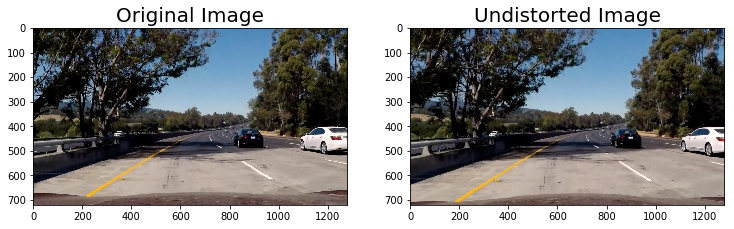

In [35]:
#reading in an image
raw_image = mpimg.imread('test_images/test5.jpg')

# Undistort a row image
image = distortion_remover(raw_image)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
plt.tight_layout()
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.2, hspace=0.1)
ax1.imshow(raw_image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(image)
ax2.set_title('Undistorted Image', fontsize=20)

# Save the result as image
plt.savefig(r"./output_images/undistorted_image.jpg")

## 2) Extract a binary image

In [36]:
# Extract the features and create a binary image
# combined_image, color_binary, combined_all = binary_image_creater(image)

# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx_binary = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(25, 255))
grady_binary = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(25, 255))
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3))

# Apply each defference color channels
S_binary   = HLS_thresh(image, channel="s_channel", hls_thresh=(200, 255))
L_binary   = HLS_thresh(image, channel="l_channel", hls_thresh=(200, 255))

# Combined result of Sobel_x and S-channel in HLS solor space
color_binary = np.dstack(( np.zeros_like(gradx_binary), gradx_binary, S_binary))
#print(np.shape(color_binary))

# Combined image SobelX and S-Channel 
combined_image = np.zeros_like(dir_binary)
combined_image[((gradx_binary == 1) | (S_binary == 1) ) | (L_binary == 1)] = 1
#print(np.shape(combined_image))

# Combined ALL image
combined_all = np.zeros_like(dir_binary)
combined_all[((gradx_binary == 1) & (grady_binary == 1)) \
            | ((mag_binary == 1) & (dir_binary == 1)) | (S_binary == 1) | (L_binary == 1)] = 1
#print(np.shape(combined_all))


### Sample: plot the result image from features extraction

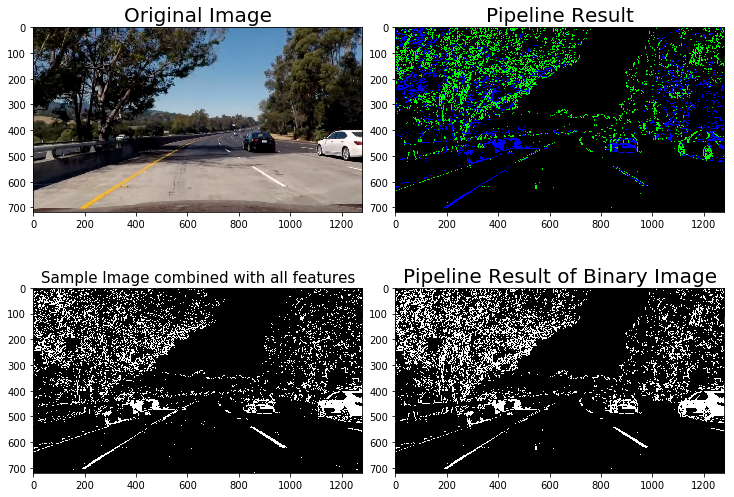

In [37]:
# Plot the result with 
f, ( (ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=20)

ax2.imshow(color_binary)
ax2.set_title('Pipeline Result', fontsize=20)

ax3.imshow(combined_all, cmap='gray')
ax3.set_title('Sample Image combined with all features', fontsize=15)

ax4.imshow(combined_image, cmap='gray')
ax4.set_title('Pipeline Result of Binary Image', fontsize=20)

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.1, hspace=0.3)

# Save the result as image
plt.savefig(r"./output_images/binary_image.jpg")

### Sample: plot the example image with each features

(720, 1280, 3)
(720, 1280)


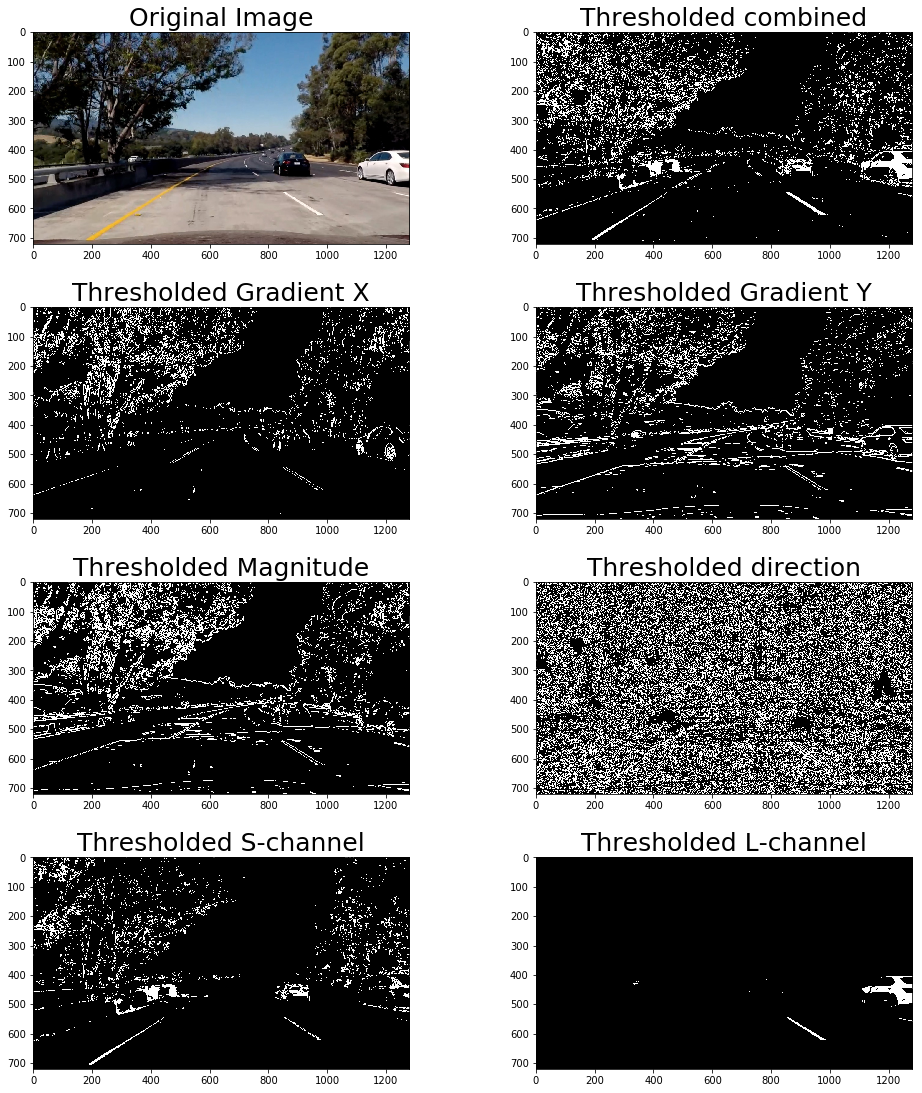

In [38]:
#def binary_image_creater(image):
""" Function: Make binary image with image features
    arg: RGB image
    return: binary image result,
            color_binary_image (its for develop),
            binary image crated with all features (its for develop)"""
# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx_binary = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(25, 255))
grady_binary = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(25, 255))
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3))

# Apply each defference color channels
S_binary   = HLS_thresh(image, channel="s_channel", hls_thresh=(200, 255))
L_binary   = HLS_thresh(image, channel="l_channel", hls_thresh=(220, 255))

# Combined result of Sobel_x and S-channel in HLS solor space
color_binary = np.dstack(( np.zeros_like(gradx_binary), gradx_binary, S_binary))
print(np.shape(color_binary))

# Combined image SobelX and S-Channel 
combined_image = np.zeros_like(dir_binary)
combined_image[((gradx_binary == 1) | (S_binary == 1) )] = 1
print(np.shape(combined_image))

# Combined ALL image
combined_all = np.zeros_like(dir_binary)
combined_all[((gradx_binary == 1) & (grady_binary == 1)) \
                 | ((mag_binary == 1) & (dir_binary == 1)) | (S_binary == 1) | (L_binary == 1)] = 1
    

# Plot the result
#f, ( (ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7,ax8) ) = plt.subplots(4, 2, figsize=(24*4/3, 9*4/3))
#f, ( (ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7,ax8) ) = plt.subplots(4, 2, figsize=(24*4/3*2, 9*4/3*2))
f, ( (ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7,ax8) ) = plt.subplots(4, 2, figsize=(16, 18))
f.tight_layout()
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.2, hspace=0.3)

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=25)

ax2.imshow(combined_all, cmap='gray')
ax2.set_title('Thresholded combined', fontsize=25)

ax3.imshow(gradx_binary, cmap='gray')
ax3.set_title('Thresholded Gradient X', fontsize=25)

ax4.imshow(grady_binary, cmap='gray')
ax4.set_title('Thresholded Gradient Y', fontsize=25)

ax5.imshow(mag_binary, cmap='gray')
ax5.set_title('Thresholded Magnitude', fontsize=25)

ax6.imshow(dir_binary, cmap='gray')
ax6.set_title('Thresholded direction', fontsize=25)

ax6.imshow(dir_binary, cmap='gray')
ax6.set_title('Thresholded direction', fontsize=25)

ax7.imshow(S_binary, cmap='gray')
ax7.set_title('Thresholded S-channel', fontsize=25)

ax8.imshow(L_binary, cmap='gray')
ax8.set_title('Thresholded L-channel', fontsize=25)

plt.savefig(r"./output_images/feature_extracted_image.jpg")

## 3) Perfrom a perspective image

In [39]:
# Warping the image
warped_binary_img, M, Minv = warp_performer(combined_image)
print(warped_binary_img.shape)

(720, 1280)


### Sample: plot the example perspective transform

(720, 1280, 3)
[[  580.   460.]
 [  200.   719.]
 [ 1110.   719.]
 [  700.   460.]]
[[  200.     0.]
 [  200.   719.]
 [ 1110.   719.]
 [ 1110.     0.]]


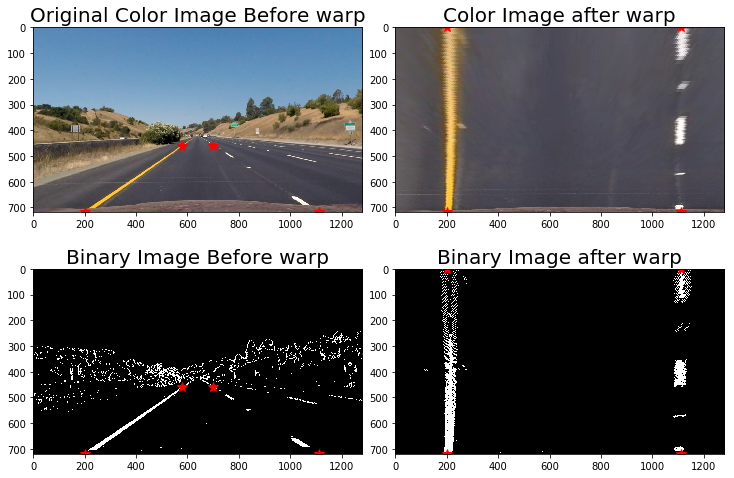

In [40]:
#def warp_performer(img):
""" function: Transform an camera viewing image into Bird's eye view
    arg: vcamera image
    retunr: an image from bird's eye view """

# Set RGB color image
#reading in an image
raw_image = mpimg.imread('test_images/straight_lines1.jpg')
# Undistort a row image
img = distortion_remover(raw_image)
img_binary, img_binary_color, img_binary_all = binary_image_creater(img)

# Warping the image
warped_img, M, Minv = warper(img, src, dst)
warped_img_binary, warped_img_binary_color, warped_img_binary_all = binary_image_creater(warped_img)

# Get the image size
img_size = img.shape
print(img_size)
# Setting the warp points
x_src_offset = 60
y_src_offset = 100
x_dst_offset = 120 # 55
y_dst_offset = 150 # 55

src = np.float32(
    [[(img_size[1]  / 2) - x_src_offset , img_size[0] / 2 + y_src_offset],
    [((img_size[1]  / 4) - 120)         , img_size[0]-1],
    [(img_size[1]*3 / 4) + 150          , img_size[0]-1],
    [(img_size[1]   / 2  + x_src_offset), img_size[0] / 2 + y_src_offset]])
dst = np.float32(
    [[(img_size[1]/4 - x_dst_offset)    , 0],
    [(img_size[1] /4 - x_dst_offset)    , img_size[0]-1],
    [(img_size[1] *3 / 4 + y_dst_offset), img_size[0]-1],
    [(img_size[1] *3 / 4 + y_dst_offset), 0]])

# Plot the result
f, ( (ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))
f.tight_layout()
#plt.subplots_adjust(hspace=0.3)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.1, hspace=0.1)

ax1.imshow(img)
ax1.set_title('Original Color Image Before warp', fontsize=20)
X  = [src[0,0], src[1,0], src[2,0], src[3,0]]
Y  = [src[0,1], src[1,1], src[2,1], src[3,1]]
ax1.plot(X,Y,"r*",markersize=10)

ax2.imshow(warped_img)
ax2.set_title('Color Image after warp', fontsize=20)
X  = [dst[0,0], dst[1,0], dst[2,0], dst[3,0]]
Y  = [dst[0,1], dst[1,1], dst[2,1], dst[3,1]]
ax2.plot(X, Y,"r*",markersize=10)

ax3.imshow(img_binary, cmap='gray')
ax3.set_title('Binary Image Before warp', fontsize=20)
X  = [src[0,0], src[1,0], src[2,0], src[3,0]]
Y  = [src[0,1], src[1,1], src[2,1], src[3,1]]
ax3.plot(X,Y,"r*",markersize=10)

ax4.imshow(warped_img_binary, cmap='gray')
ax4.set_title('Binary Image after warp', fontsize=20)
X  = [dst[0,0], dst[1,0], dst[2,0], dst[3,0]]
Y  = [dst[0,1], dst[1,1], dst[2,1], dst[3,1]]
ax4.plot(X, Y,"r*",markersize=10)

# Save the result as image
plt.savefig(r"./output_images/warped_image.jpg")

# debug
print(src)
print(dst)

## 4) Find Lane Lines

### Sliding Window Approach

left_fit
[  3.61848787e-04  -4.40925209e-01   3.11569294e+02]
right_fit
[  1.54003964e-04  -3.36496921e-01   1.29871544e+03]


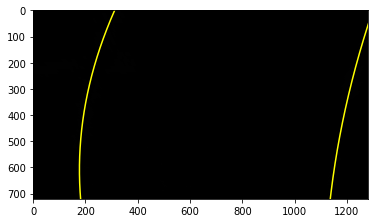

In [41]:
# Find the lane line with sliding windows
left_fit, right_fit, ploty, left_fitx, right_fitx = calc_fit(warped_binary_img)

# Ready fot the test plot
# Create an output image to draw on and  visualize the result
out_img = np.dstack((warped_binary_img, warped_binary_img, warped_binary_img))*255

plt.imshow(out_img)
plt.plot(left_fitx,  ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

# Debug
print("left_fit")
print(left_fit)
print("right_fit")
print(right_fit)

### Analysis the Position of lane line

(720, 1280)


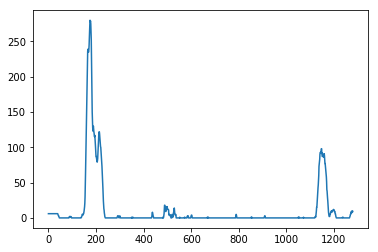

In [42]:
# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements
# Apply each of the thresholding functions
gradx_binary = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
# Apply each defference color channels
S_binary   = HLS_thresh(image, channel="s_channel", hls_thresh=(170, 255))

# Combined ALL image
combined_image = np.zeros_like(gradx_binary)
combined_image[((gradx_binary == 1)  | (S_binary == 1))] = 1

# Warping the image
warped_binary_img, M, Minv = warp_performer(combined_image)
print(warped_binary_img.shape)
histogram = np.sum(warped_binary_img[warped_binary_img.shape[0]//2:,:], axis=0)
plt.plot(histogram)


### Sample: plot the result example with Siliding Window approach

binary_warped.shape
(720, 1280)
left_fit
[  3.48123594e-04  -4.30413045e-01   3.08769956e+02]
right_fit
[ -7.93208168e-05  -1.15132172e-01   1.25129031e+03]


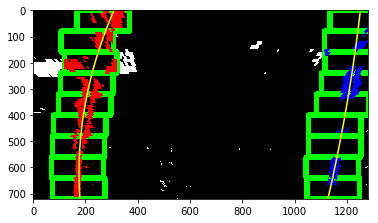

In [43]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

binary_warped = warped_binary_img
print("binary_warped.shape")
print(binary_warped.shape)

#def calc_fit(binary_warped):
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[np.int(binary_warped.shape[0]/2):,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)

# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
#print(nonzerox)

# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):

    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin

    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 20) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 20) 

    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & \
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds= ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & \
                          (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)

    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
    
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
# paint colors on lane line image
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

# Save the result as image
plt.savefig(r"./output_images/sliding_window_approach_image.jpg")

# Debug
print("left_fit")
print(left_fit)
print("right_fit")
print(right_fit)

## Region of interest Approach

In [44]:
# Find the lane line with assuming
left_fit, right_fit, ploty, left_fitx, right_fitx = calc_fit_assume(warped_binary_img, left_fit, right_fit)

# Debug
print("left_fit")
print(left_fit)
print("right_fit")
print(right_fit)

left_fit
[  2.74615789e-04  -4.00543955e-01   3.15357259e+02]
right_fit
[  6.61722248e-05  -2.54804655e-01   1.28204230e+03]


### Sample plot the result example with Region of interest

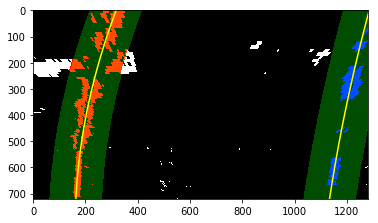

In [45]:
# Test plot

binary_warped = warped_binary_img

# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx_for_fit  = nonzerox[left_lane_inds]
lefty_for_fit  = nonzeroy[left_lane_inds] 
rightx_for_fit = nonzerox[right_lane_inds]
righty_for_fit = nonzeroy[right_lane_inds]
    
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty_for_fit,   leftx_for_fit, 2)
right_fit = np.polyfit(righty_for_fit, rightx_for_fit, 2)
    
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx  = left_fit[0] *ploty**2 + left_fit[1] *ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]


# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

# Save the result as image
plt.savefig(r"./output_images/ROI_image.jpg")

## Calculate the curvature of the road and lane line

In [46]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1926.74 1908.48 [pixcel]

2219.98928564 6416.87739948


In [47]:
# Calculate the curvature
curvature = calc_curvature(ploty, left_fitx, right_fitx)

# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
print(curvature, "m")

2219.98928564 m 6416.87739948 m
1381.80130835 m


## Calculate the Offset distance between the center of the road and of the vehicle

In [48]:
# Calculate the offset[m]
offset_m = calc_offset(image, left_fitx, right_fitx)

# Now our offet distance is in meters
print(offset_m, 'm')


0.045479876343 m


## Visualizet the result

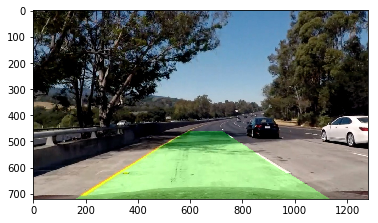

In [50]:
# Create the visualization with Function
result =  visualize_result(image, warped_binary_img, Minv, left_fitx, right_fitx, ploty)
# Visualize
plt.imshow(result)

# Save the result as image
plt.savefig(r"./output_images/pipeline_result_image.jpg")

### Add the data text to the result image

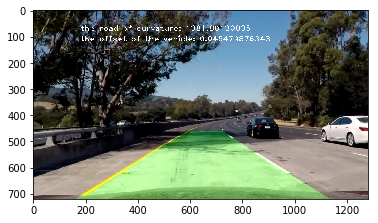

In [51]:
result_with_text = add_data_to_image(result, curvature, offset_m)
# Visualize
plt.imshow(result_with_text)

# Save the result as image
plt.savefig(r"./output_images/pipeline_result_image_with_texts.jpg")



## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In this process thet target file is straight_lines2.jpg
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


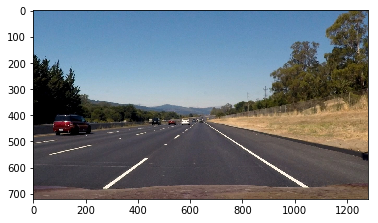

In [52]:
import os
images = os.listdir("test_images/")

#print(images)
src_img = images[1]
print("In this process thet target file is "+src_img)
#reading in an image
img = mpimg.imread("test_images/"+src_img)

#printing out some stats and plotting
print('This image is:', type(img), 'with dimensions:', img.shape)
plt.imshow(img)
# if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Build a Lane Finding Pipeline

This is the pipeline for Finding Lane Line on all test_images. 

In [53]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        
        # was the line detected in the last iteration?
        self.detected = False  
        
        # x values of the last n fits of the line
        self.pre_fitx = None #[]
        #average x values of the fitted line over the last n iterations
        self.best_fitx = None
        
        #polynomial coefficients averaged over the last n iterations
        self.coeff = None
        #polynomial coefficients for the most recent fit
        self.pre_coeff = None #[np.array([False])]  

        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        #self.allx = None  
        #y values for detected line pixels
        #self.ally = None

        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None
        
    def reset(self):

        self.best_fitx = self.pre_fitx        
        self.coeff = self.pre_coeff #[np.array([False])]  
    
    def update(self):
        self.pre_coeff = self.coeff
        self.pre_fitx =  self.best_fitx
    
    def detect_Success(self):
        # was the line detected in the last iteration?
        self.detected = True  

    def detect_Fail(self):
        # was the line detected in the last iteration?
        self.detected = False
    
    def is_Detect(self):
        return self.detected

        
        
# Define a class to receive the characteristics of each line detection
class Road():
    def __init__(self):
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #width in meters between the lanes
        self.width_m = None 
        
        #radius of curvature of the line in some units
        self.pre_radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.pre_line_base_pos = None
        #width in meters between the lanes
        self.pre_width_m = None 
    
    
        #radius of curvature of the line in some units
        self.diff_curv = None 
        #distance in meters of vehicle center from the line
        self.diff_offset = None
        #width in meters between the lanes
        self.diff_width_m = None 
    
    def update(self):
        #radius of curvature of the line in some units
        self.pre_radius_of_curvature = self.radius_of_curvature 
        #distance in meters of vehicle center from the line
        self.pre_line_base_pos = self.line_base_pos
        #width in meters between the lanes
        self.pre_width_m = self.width_m 
    
    def reset(self):
        #radius of curvature of the line in some units
        self.radius_of_curvature = self.pre_radius_of_curvature 
        #distance in meters of vehicle center from the line
        self.line_base_pos = self.pre_line_base_pos
        #width in meters between the lanes
        self.width_m = self.pre_width_m 


In [54]:
# Parameter for Low pass filter
low_pass_param = 0.2

thre_curvature = 1000.0 # [m]
thre_offset_m = 1.5 # [m]
thre_diff_m = 3.5 # [m]

right_lane = Line()
left_lane  = Line()
road = Road()

ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

def calc_width(left_lane_best_fitx, right_lane_best_fitx):
    
    road_width_pixcel = np.abs((right_lane_best_fitx[-1] - left_lane_best_fitx[-1]))
    road_width_m = road_width_pixcel * xm_per_pix

    return road_width_m
    
def sanitary_check():    
    # init
    is_error = False
    #road.radius_of_curvature = curvature
    #road.pre_line_base_pos = offset_m
    
    # Firsst time
    if (road.pre_radius_of_curvature == None) and (road.pre_line_base_pos == None) and (road.pre_width_m == None):
        return is_error
        
    # Check the curvature and vehicle position and the horizaontal distance of the lane Lines
    diff_curv   = np.abs(road.radius_of_curvature - road.pre_radius_of_curvature)
    diff_offset = np.abs(road.line_base_pos - road.pre_line_base_pos)
    diff_width_m= np.abs(road.width_m - road.pre_width_m)
    
    if ( (diff_curv > thre_curvature) | (diff_offset > thre_offset_m) | (diff_width_m > thre_diff_m)):
        # Error
        is_error = True
    else:
        # Not Error
        is_error = False
    
    # store
    road.diff_curv   = diff_curv
    road.diff_offset = diff_offset
    road.diff_width_m= diff_width_m

    return [is_error, diff_curv, diff_offset, diff_width_m]

def process_image(raw_image):
    """ Function: Main pieline process for detecting the lane line
        Return  : result image """
    # Init
    
    # Undistort a raw image
    image = distortion_remover(raw_image)
    # Extract the features and create a binary image
    combined_image, color_binary, combined_all = binary_image_creater(image)
    # Warping the image
    warped_binary_img, M, Minv = warp_performer(combined_image)
    
    if left_lane.is_Detect() == False | right_lane.is_Detect() == False:
        # Find the lane line with sliding windows
        left_fit, right_fit, ploty, left_fitx, right_fitx = calc_fit(warped_binary_img)
        # 
        left_lane.coeff  = left_fit
        right_lane.coeff = right_fit
        left_lane.best_fitx  = left_fitx
        right_lane.best_fitx = right_fitx
        
    else:        
        # Find the lane line with assuming
        left_fit, right_fit, ploty, left_fitx, right_fitx = \
            calc_fit_assume(warped_binary_img, left_lane.coeff, right_lane.coeff)
         
        # Smoothing with Low pass filter
        #if pre_left_fit and pre_right_fit:
        left_lane.coeff  = low_pass_param*np.array(left_fit)  + (1-low_pass_param)*left_lane.pre_coeff
        right_lane.coeff = low_pass_param*np.array(right_fit) + (1-low_pass_param)*right_lane.pre_coeff
        left_lane.best_fitx  = low_pass_param*np.array(left_fitx)  + (1-low_pass_param)*np.array(left_lane.pre_fitx)
        right_lane.best_fitx = low_pass_param*np.array(right_fitx) + (1-low_pass_param)*np.array(right_lane.pre_fitx)
        
    # calculate the curvature
    curvature = calc_curvature(ploty, left_lane.best_fitx, right_lane.best_fitx)
    # Calculate the offset[m]
    offset_m = calc_offset(image, left_lane.best_fitx, right_lane.best_fitx)
    # Calculate the road width[m]
    width_m = calc_width(left_lane.best_fitx, right_lane.best_fitx)
        
    # low pass filter
    if road.pre_radius_of_curvature and road.pre_line_base_pos and road.pre_width_m: 
        road.radius_of_curvature = low_pass_param*curvature + (1-low_pass_param)*road.pre_radius_of_curvature
        road.line_base_pos       = low_pass_param*offset_m  + (1-low_pass_param)*road.pre_line_base_pos
        road.width_m             = low_pass_param*width_m   + (1-low_pass_param)*road.pre_width_m
        LPF = "ON"
    else:
        road.radius_of_curvature = curvature
        road.line_base_pos       = offset_m
        road.width_m             = width_m
        LPF = "OFF"
        
    # Sanitary Check
    #[is_sanitary_check, diff_curv, diff_offset, diff_width_m] = sanitary_check()
    is_sanitary_check = sanitary_check()
    
    if is_sanitary_check == True:
        # Detect Fail
        left_lane.detect_Fail()
        right_lane.detect_Fail()
        # Reset
        left_lane.reset()
        right_lane.reset()
        road.reset()
        error_code = "sanitary_check"
        
    else:
        # Detect Success
        left_lane.detect_Success()
        right_lane.detect_Success()
        # update
        left_lane.update() 
        right_lane.update()
        road.update()
        error_code = "OK"

    # reverse the image with camera image
    #result = visualize_result(image, warped_binary_img, Minv, left_fitx, right_fitx, ploty)
    result = visualize_result(image, warped_binary_img, Minv, left_lane.best_fitx, right_lane.best_fitx, ploty)
    
    # then put the text itself
    result = add_data_to_image(result, road.radius_of_curvature, road.line_base_pos)
    
    # debug
    debug_text1 = "diff_curv: " + str(road.diff_curv)
    debug_text2 = "diff_offset: " + str(road.diff_offset)
    debug_text3 = "diff_m: " + str(road.diff_width_m)
    debug_text4 = "curvature: " + str(curvature)
    debug_text5 = "offset: " + str(offset_m)
    debug_text6 = "error_code: " + str(error_code)

    cv2.putText(result, debug_text1, (180,200), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255), 2)
    cv2.putText(result, debug_text2, (180,220), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255), 2)
    cv2.putText(result, debug_text3, (180,240), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255), 2)
    cv2.putText(result, debug_text4, (180,260), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255), 2)    
    cv2.putText(result, debug_text5, (180,280), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255), 2)
    cv2.putText(result, debug_text6, (180,300), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255), 2)
    #cv2.putText(result, debug_text7, (180,240), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255), 2)
    #cv2.putText(result, debug_text4, (180,260), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255), 2)    
    
    # return an image with lane line
    return result


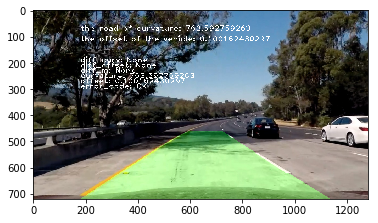

In [55]:
# Read an image file
raw_image = mpimg.imread('test_images/test5.jpg')

result = process_image(raw_image)
plt.imshow(result)

## Test for Pipeline on Videos

In this cell, Drawing lanes over video!
I evaluate my solution on 3 provided videos:

`project.mp4`

`challenge.mp4`

`harder_challenge.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [9]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## 1) Project.mp4

In [35]:
project_output = 'output_images/project.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video output_images/project.mp4
[MoviePy] Writing video output_images/project.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [05:11<00:00,  4.08it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project.mp4 

Wall time: 5min 12s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [36]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

## 2) challenge.mp4

In [10]:
challenge_output = 'output_images/challenge_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('challenge_video.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video output_images/challenge_video.mp4
[MoviePy] Writing video output_images/challenge_video.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [01:58<00:00,  4.03it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/challenge_video.mp4 

Wall time: 1min 59s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

## 3) Harder_challenge.mp4

In [14]:
harder_challenge_output = 'output_images/harder_challenge_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('harder_challenge_video.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(harder_challenge_output, audio=False)

[MoviePy] >>>> Building video output_images/harder_challenge_video.mp4
[MoviePy] Writing video output_images/harder_challenge_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1199/1200 [05:16<00:00,  3.84it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/harder_challenge_video.mp4 

Wall time: 5min 17s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))